In [2]:
#CONDA ENV == py_374 (BASE)

#Import packages
#---------------------------------------
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import tension
import tensorflow as tf #NB MUST BE TF < 3.11
from tension.constrained import ConstrainedNoFeedbackESN, BioFORCEModel
from sklearn.decomposition import PCA
import pkg_resources
%load_ext autoreload

#Display versions
#--------------------------------------
pkg_resources.get_distribution("tensorflow").version
sys.version

# Define paths
#----------------------------------------------------------------------
s_data = '/mnlsc/data/MCBL4/dburrows/'
s_code = '~/Documents/multiscale_dev_dynamics'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [3]:
!wget https://data.mendeley.com/public-files/datasets/9936ryd5h7/files/7ac6616e-b6f7-4773-b254-b088147f68e6/file_downloaded 

zsh:1: command not found: wget


In [8]:
with np.load(s_data + '/dev/file_downloaded', allow_pickle=True) as data:
  keys = ['mask_name', 'cell_ids', 'tracez', 'all_coords']
  i = -4 # index corresponding to desired data 
  cell_id = list(data['cell_ids'])[i]  
  print(data['mask_name'][i])
  print(data['tracez'].shape)
  print(data['tracez'][cell_id].shape) 
  target = data['tracez'][cell_id] # based on cell_id's of neurons in desired area of brain
  target = target[:100,:50]
target.shape

Telencephalon - Subpallium
(11190, 2500)
(365, 2500)


(100, 50)

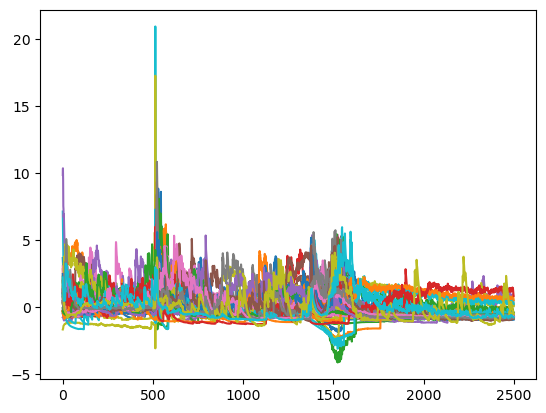

In [163]:
for i in range(50):
    plt.plot(target[i])
plt.show()

# Define training parameters

In [9]:
target_transposed = np.transpose(target).astype(np.float32) # convert to shape (timestep, number of neurons)
u = 1 # number of inputs, by default the forward pass does not use inputs so this is a stand-in
n = target_transposed.shape[1] # number of neurons
tau = 1.5 # neuron time constant
dt = 0.25 # time step
alpha = 1 # gain on P matrix at initialization
m = n # output dim equals the number of recurrent neurons
g = 1.25 # gain parameter controlling network chaos
p_recurr = 0.5 # (1 - p_recurr) of recurrent weights are randomly set to 0 and not trained
max_epoch = 100

structural_connectivity = np.ones((n, n)) # region connectivity matrix; set to all 1's since only looking at one subsection of the brain
noise_param = (0, 0.001) # mean and std of white noise injected to the forward pass

x_t = np.zeros((target_transposed.shape[0], u)).astype(np.float32) # stand-in input

In [10]:
class EarlyStoppingByLossVal(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super().__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        
        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Train the model

In [38]:
x_t.shape, target_transposed.shape

((50, 1), (50, 365))

In [13]:
%%time
tf.random.set_seed(123)

earlystopping = EarlyStoppingByLossVal(monitor="val_mae", value=0.25)
esn_layer = ConstrainedNoFeedbackESN(units=n,
                                     activation='tanh',
                                     dtdivtau=dt/tau,
                                     p_recurr=p_recurr,
                                     structural_connectivity=structural_connectivity,
                                     noise_param=noise_param,
                                     seed=123)

model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
model.compile(metrics=["mae"])

# pass the input as validation data for early stopping
history = model.fit(x=x_t, 
                    y=target_transposed, 
                    epochs=max_epoch,
                    #callbacks=[earlystopping],
                    validation_data=(x_t, target_transposed))

Epoch 1/100
50/50 [==============================] - 1s 7ms/step - mae: 0.6174 - val_loss: 2.3786 - val_mae: 2.3786
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - mae: 0.3204 - val_loss: 0.3791 - val_mae: 0.3791
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - mae: 0.2191 - val_loss: 0.2948 - val_mae: 0.2948
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - mae: 0.2071 - val_loss: 0.5761 - val_mae: 0.5761
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - mae: 0.1927 - val_loss: 0.1955 - val_mae: 0.1955
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - mae: 0.1857 - val_loss: 0.2013 - val_mae: 0.2013
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - mae: 0.1618 - val_loss: 0.1615 - val_mae: 0.1615
Epoch 8/100
50/50 [==============================] - 0s 4ms/step - mae: 0.1452 - val_loss: 0.1547 - val_mae: 0.1547
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - mae: 

# Predict

In [14]:
%%time
prediction = model.predict(x_t)
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed)))

50/50 [==============================] - 0s 600us/step
tf.Tensor(0.14039944, shape=(), dtype=float32)
CPU times: user 244 ms, sys: 15.6 ms, total: 259 ms
Wall time: 210 ms


Text(0.5, 0, 'Time (s)')

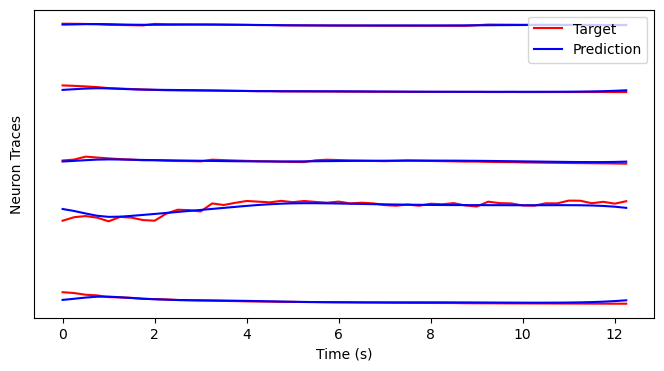

In [15]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
num_plot = np.arange(5)

for idx, i in enumerate(num_plot):
  ax.plot(np.arange(0, x_t.shape[0]) * dt, target_transposed[:,i] + 10 * idx, color='r')
  ax.plot(np.arange(0, 50) * dt, prediction[:,i] + 10 * idx, color='b')
  if i == num_plot[-1]:
    ax.legend(['Target', 'Prediction'])
ax.set_yticks([])
ax.set_ylabel('Neuron Traces')
ax.set_xlabel('Time (s)')

Text(0, 0.5, 'PC2')

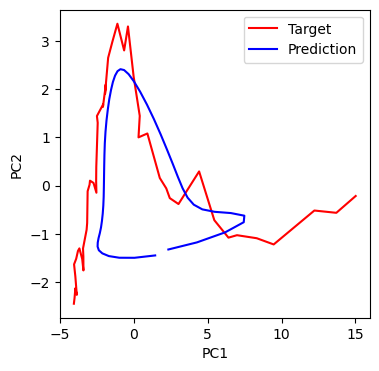

In [16]:
assert prediction.shape == target_transposed[:200].shape
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed[:200])
pred_pca = pca.transform(prediction)
assert target_pca.shape == pred_pca.shape

plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

# Batch train model



In [25]:
#SAVE LOADING DATA

with np.load(s_data + '/dev/file_downloaded', allow_pickle=True) as data:
  keys = ['mask_name', 'cell_ids', 'tracez', 'all_coords']
  i = -4 # index corresponding to desired data 
  cell_id = list(data['cell_ids'])[i]  
  print(data['mask_name'][i])
  print(data['tracez'].shape)
  print(data['tracez'][cell_id].shape) 
  target = data['tracez'][cell_id] # based on cell_id's of neurons in desired area of brain
  target = target[200:300,900:1100]
target.shape

Telencephalon - Subpallium
(11190, 2500)
(365, 2500)


(100, 200)

In [29]:
#WRITE AS FUNCTION - save target!!!

#Define PARS
target_transposed = np.transpose(target).astype(np.float32) # convert to shape (timestep, number of neurons)
u = 1 # number of inputs, by default the forward pass does not use inputs so this is a stand-in
n = target_transposed.shape[1] # number of neurons
tau = 1.5 # neuron time constant
dt = 0.25 # time step
alpha = 1 # gain on P matrix at initialization
m = n # output dim equals the number of recurrent neurons
g = 1.25 # gain parameter controlling network chaos
p_recurr = 0.5 # (1 - p_recurr) of recurrent weights are randomly set to 0 and not trained
max_epoch = 100

structural_connectivity = np.ones((n, n)) # region connectivity matrix; set to all 1's since only looking at one subsection of the brain
noise_param = (0, 0.001) # mean and std of white noise injected to the forward pass

x_t = np.zeros((target_transposed.shape[0], u)).astype(np.float32) # stand-in input

In [30]:
rw, iw, states, dyn = FORCE_NFESN_learn(x_t, target_transposed, units=n, activation='tanh', dt=dt, 
                                        tau=tau, p_recurr=p_recurr, structural_connectivity=structural_connectivity
                                        , noise_param=noise_param, alpha=alpha, max_epoch = 100)

Epoch 1/100
200/200 [==============================] - 1s 5ms/step - mae: 0.3879 - val_loss: 1.1019 - val_mae: 1.1019
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - mae: 0.1931 - val_loss: 0.9797 - val_mae: 0.9797
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - mae: 0.1483 - val_loss: 0.6795 - val_mae: 0.6795
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - mae: 0.1301 - val_loss: 0.7428 - val_mae: 0.7428
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - mae: 0.1192 - val_loss: 0.2556 - val_mae: 0.2556
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - mae: 0.1181 - val_loss: 0.1532 - val_mae: 0.1532
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - mae: 0.1142 - val_loss: 0.2437 - val_mae: 0.2437
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - mae: 0.1131 - val_loss: 0.1836 - val_mae: 0.1836
Epoch 9/100
200/200 [==============================] - 1

In [5]:
#==============================
def FORCE_NFESN_learn(x_t, target_transposed, units, activation, dt, tau, p_recurr, structural_connectivity, noise_param, alpha, max_epoch):
#==============================
    """
    This function performs FORCE learning in a no feedback echo state network.
    
    Inputs:
        data (np array): cells x timepoints, state vectors
        
    Returns:
        all_c (np array): 1d vector of cluster labels for each time point
        sub_c (np array): 1d vector of all unique cluster labels, that label more than a single time point
    """

    esn_layer = ConstrainedNoFeedbackESN(units=units,
                                        activation=activation,
                                        dtdivtau=dt/tau,
                                        p_recurr=p_recurr,
                                        structural_connectivity=structural_connectivity,
                                        noise_param=noise_param)

    model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
    model.compile(metrics=["mae"])

    # pass the input as validation data for early stopping
    history = model.fit(x=x_t, 
                        y=target_transposed, 
                        epochs=max_epoch,
                        #callbacks=[earlystopping],
                        validation_data=(x_t, target_transposed))
    
    prediction = model.predict(x_t)
    
    model.save_weights('model_weights.h5')
    np.save('model_states.npy',model.force_layer.states[0])
    np.save('model_dynamics.npy', prediction)

    return(esn_layer.recurrent_kernel, esn_layer.input_kernel, model.force_layer.states, prediction)


Text(0.5, 0, 'Time (s)')

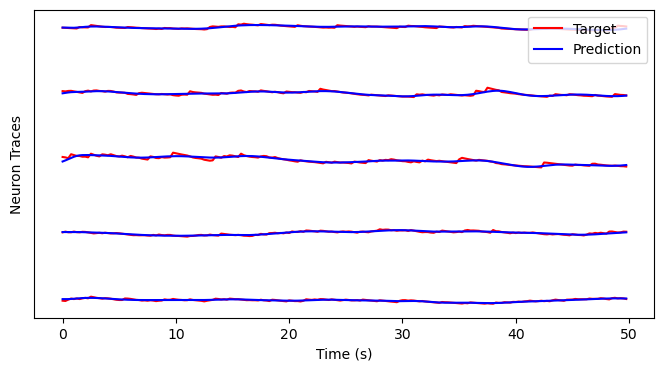

In [32]:
prediction = dyn
fig, ax = plt.subplots(1,1, figsize = (8,4))
num_plot = np.arange(5)

for idx, i in enumerate(num_plot):
  ax.plot(np.arange(0, x_t.shape[0]) * dt, target_transposed[:,i] + 10 * idx, color='r')
  ax.plot(np.arange(0, x_t.shape[0]) * dt, prediction[:,i] + 10 * idx, color='b')
  if i == num_plot[-1]:
    ax.legend(['Target', 'Prediction'])
ax.set_yticks([])
ax.set_ylabel('Neuron Traces')
ax.set_xlabel('Time (s)')

Text(0, 0.5, 'PC2')

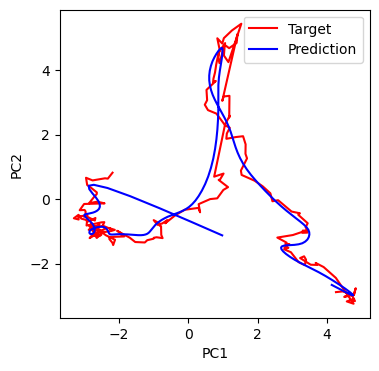

In [33]:
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed)
pred_pca = pca.transform(prediction)

plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [34]:
dyn2 = NFESN_load_checkpoint(x_t, units=n, activation='tanh', dt=dt, 
                                        tau=tau, p_recurr=p_recurr, structural_connectivity=structural_connectivity
                                        , noise_param=noise_param, alpha=alpha)


check = QC(np.load('model_dynamics.npy'), dyn2) #Quality Control


200/200 [==============================] - 0s 574us/step
Reloaded model passed QC


Text(0, 0.5, 'PC2')

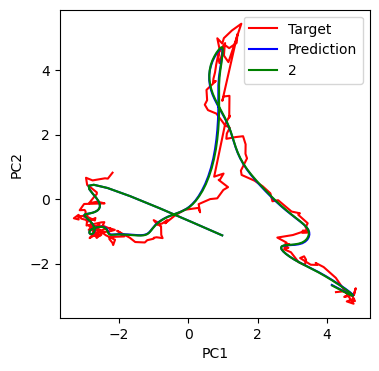

In [35]:
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed)
pred_pca = pca.transform(prediction)
_pca2 = pca.transform(dyn2)


plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.plot(_pca2[:,0], _pca2[:,1], color='green', label='2')

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [22]:
#==============================
def NFESN_load_checkpoint(x_t, units, activation, dt, tau, p_recurr, structural_connectivity, noise_param, alpha):
#==============================
    """
    This function performs FORCE learning in a no feedback echo state network.
    
    Inputs:
        data (np array): cells x timepoints, state vectors
        
    Returns:
        all_c (np array): 1d vector of cluster labels for each time point
        sub_c (np array): 1d vector of all unique cluster labels, that label more than a single time point
    """

    #Can you just load this in? 

    esn_layer = ConstrainedNoFeedbackESN(units=units,
                                        activation=activation,
                                        dtdivtau=dt/tau,
                                        p_recurr=p_recurr,
                                        structural_connectivity=structural_connectivity,
                                        noise_param=noise_param, #####
                                        initial_a = tf.constant(np.load('model_states.npy')) ###### 
                                        )

    model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
    model.build((1,1, x_t.shape[-1])) #######
    model.load_weights('model_weights.h5')
    model.compile(metrics=["mae"])

    dyn = model.predict(x_t)
    return(dyn)


In [23]:
def QC(old, new):
    dist = np.linalg.norm(np.ravel(old) - np.ravel(new))
    if dist > 1:
        print('Reloading model failed to match original model dynamics')

    else:
        print('Reloaded model passed QC')

# Perturbation simulations

In [37]:
dyn1,dyn2 = NFESN_perturb(x_t, units=n, activation='tanh', dt=dt, 
                                        tau=tau, p_recurr=p_recurr, structural_connectivity=structural_connectivity
                                        , noise_param=noise_param, alpha=alpha)

200/200 [==============================] - 0s 568us/step


Text(0, 0.5, 'PC2')

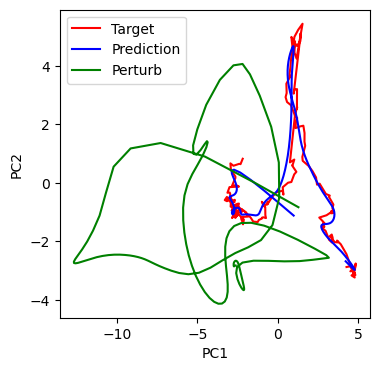

In [38]:
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed)
pred_pca = pca.transform(dyn1)
_pca = pca.transform(dyn2)


plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.plot(_pca[:,0], _pca[:,1], color='green', label='Perturb')

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [36]:
#==============================
def NFESN_perturb(x_t, units, activation, dt, tau, p_recurr, structural_connectivity, noise_param, alpha):
#==============================
    """
    This function performs FORCE learning in a no feedback echo state network.
    
    Inputs:
        data (np array): cells x timepoints, state vectors
        
    Returns:
        all_c (np array): 1d vector of cluster labels for each time point
        sub_c (np array): 1d vector of all unique cluster labels, that label more than a single time point
    """

    #Can you just load this in? 

    esn_layer = ConstrainedNoFeedbackESN(units=units,
                                        activation=activation,
                                        dtdivtau=dt/tau,
                                        p_recurr=p_recurr,
                                        structural_connectivity=structural_connectivity,
                                        noise_param=noise_param, #####
                                        initial_a = tf.constant(np.load('model_states.npy')) ###### 
                                        )

    model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
    model.build((1,1, x_t.shape[-1])) #######
    model.load_weights('model_weights.h5')
    model.compile(metrics=["mae"])

    dyn1 = model.predict(x_t)

    r_weights = esn_layer.recurrent_kernel
    inp_weights = esn_layer.input_kernel
    prac = np.asarray(r_weights)
    prac[0] = 1
    esn_layer.recurrent_kernel.assign(prac) 

    dyn2 = model.predict(x_t)
    return(dyn1, dyn2)


In [98]:
prac = np.asarray(r_weights)
prac[0] = 1
prac

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        ,  0.        , -0.16035251, ..., -0.26639014,
         0.        ,  0.        ],
       [ 0.        , -0.00274575,  0.        , ...,  0.        ,
        -0.10611878,  0.        ],
       ...,
       [-0.04807381,  0.        ,  0.        , ...,  0.        ,
        -0.16074912,  0.        ],
       [-0.05972771,  0.        ,  0.        , ..., -0.19677565,
         0.        , -0.13212039],
       [ 0.0756534 , -0.4313363 ,  0.        , ...,  0.        ,
         0.06207396,  0.        ]], dtype=float32)

In [114]:
prac = np.asarray(inp_weights)
prac+= 5
prac

array([[3.1706219, 6.290206 , 7.4587827, 5.0446396, 5.7221484, 5.182867 ,
        4.465847 , 5.680422 , 3.853853 , 6.2773075, 4.427032 , 5.5154095,
        5.406946 , 6.4203596, 5.8304253, 5.28785  , 7.001559 , 6.8651156,
        6.26184  , 4.2136183, 4.686938 , 6.043424 , 7.3441715, 5.8901787,
        5.732649 , 7.8536615, 5.355988 , 3.4608128, 6.3309574, 5.5644236,
        6.323783 , 5.482157 , 6.1201105, 3.7476196, 3.9512637, 5.5520263,
        5.611659 , 4.1644897, 7.1783094, 5.8421154, 5.5262485, 6.386204 ,
        5.6745796, 4.69211  , 4.499682 , 8.014609 , 6.617285 , 7.1808023,
        5.9337835, 6.8245153, 8.129367 , 5.5934668, 6.6001873, 6.0747566,
        5.530812 , 7.2228794, 7.1809707, 5.3651214, 5.3047557, 5.6962867,
        5.5618057, 5.6465883, 6.5228634, 6.399012 , 6.8758006, 6.206006 ,
        5.931895 , 5.6543403, 3.6140153, 4.9379816, 6.1641207, 6.816972 ,
        5.763196 , 5.7984924, 5.5163026, 5.375701 , 6.349229 , 7.003688 ,
        4.8103337, 4.664808 , 5.051764

In [115]:
esn_layer.recurrent_kernel.assign(prac) 
# esn_layer.input_kernel.assign(inp_weights1*2)

ValueError: Cannot assign value to variable ' rnn_7/constrained_no_feedback_esn_7/recurrent_kernel:0': Shape mismatch.The variable shape (365, 365), and the assigned value shape (1, 365) are incompatible.

In [116]:
#esn_layer.recurrent_kernel.assign(prac) 
esn_layer.input_kernel.assign(prac)

<tf.Variable 'UnreadVariable' shape=(1, 365) dtype=float32, numpy=
array([[3.1706219, 6.290206 , 7.4587827, 5.0446396, 5.7221484, 5.182867 ,
        4.465847 , 5.680422 , 3.853853 , 6.2773075, 4.427032 , 5.5154095,
        5.406946 , 6.4203596, 5.8304253, 5.28785  , 7.001559 , 6.8651156,
        6.26184  , 4.2136183, 4.686938 , 6.043424 , 7.3441715, 5.8901787,
        5.732649 , 7.8536615, 5.355988 , 3.4608128, 6.3309574, 5.5644236,
        6.323783 , 5.482157 , 6.1201105, 3.7476196, 3.9512637, 5.5520263,
        5.611659 , 4.1644897, 7.1783094, 5.8421154, 5.5262485, 6.386204 ,
        5.6745796, 4.69211  , 4.499682 , 8.014609 , 6.617285 , 7.1808023,
        5.9337835, 6.8245153, 8.129367 , 5.5934668, 6.6001873, 6.0747566,
        5.530812 , 7.2228794, 7.1809707, 5.3651214, 5.3047557, 5.6962867,
        5.5618057, 5.6465883, 6.5228634, 6.399012 , 6.8758006, 6.206006 ,
        5.931895 , 5.6543403, 3.6140153, 4.9379816, 6.1641207, 6.816972 ,
        5.763196 , 5.7984924, 5.5163026, 5.37

In [100]:
%%time
perturb_rw = model.predict(x_t)
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed)))

50/50 [==============================] - 0s 602us/step
tf.Tensor(0.21687108, shape=(), dtype=float32)
CPU times: user 103 ms, sys: 37.8 ms, total: 141 ms
Wall time: 85.5 ms


Text(0, 0.5, 'PC2')

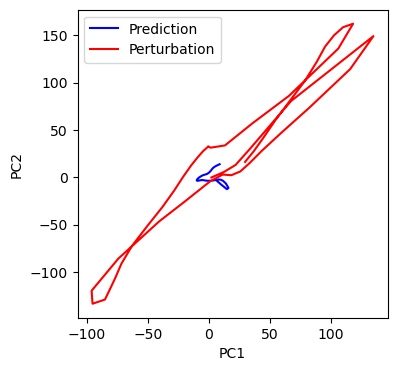

In [103]:
assert prediction.shape == target_transposed[:200].shape
pca = PCA(n_components=2)
target_pca = pca.fit_transform(prediction)
pred_pca = pca.transform(prediction)
perturb_pca = pca.transform(perturb_rw)

plt.figure(figsize=(4,4))
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.plot(perturb_pca[:,0], perturb_pca[:,1], color='red', label='Perturbation')

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [117]:
%%time
perturb_inp = model.predict(x_t)
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed)))

50/50 [==============================] - 0s 547us/step
tf.Tensor(0.21687108, shape=(), dtype=float32)
CPU times: user 146 ms, sys: 4.86 ms, total: 151 ms
Wall time: 95.2 ms


Text(0, 0.5, 'PC2')

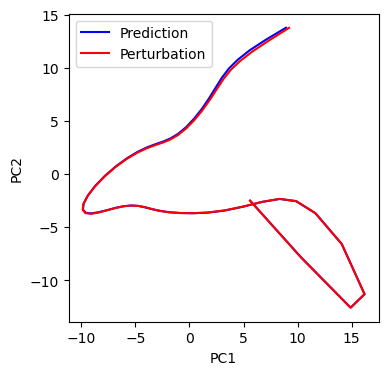

In [118]:
assert prediction.shape == target_transposed[:200].shape
pca = PCA(n_components=2)
target_pca = pca.fit_transform(prediction)
pred_pca = pca.transform(prediction)
perturb_pca = pca.transform(perturb_inp)

plt.figure(figsize=(4,4))
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.plot(perturb_pca[:,0], perturb_pca[:,1], color='red', label='Perturbation')

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

# Build reduced FORCE model

In [204]:
#SAVE LOADING DATA

with np.load('/Users/dominicburrows/Dropbox/PhD/Analysis/Project/bin/hadjiabadi-1', allow_pickle=True) as data:
  keys = ['mask_name', 'cell_ids', 'tracez', 'all_coords']
  i = -4 # index corresponding to desired data 
  cell_id = list(data['cell_ids'])[i]  
  print(data['mask_name'][i])
  print(data['tracez'].shape)
  print(data['tracez'][cell_id].shape) 
  target = data['tracez'][cell_id] # based on cell_id's of neurons in desired area of brain
  target = target[200:210,900:1000]
target.shape

Telencephalon - Subpallium
(11190, 2500)
(365, 2500)


(10, 100)

In [193]:
%%time
tf.random.set_seed(123)

esn_layer = ConstrainedNoFeedbackESN(units=n,
                                     activation='tanh',
                                     dtdivtau=dt/tau,
                                     p_recurr=p_recurr,
                                     structural_connectivity=structural_connectivity,
                                     noise_param=noise_param,
                                     seed=123)

model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
model.compile(metrics=["mae"])

# pass the input as validation data for early stopping
history = model.fit(x=x_t, 
                    y=target_transposed, 
                    epochs=max_epoch,
                    #callbacks=[earlystopping],
                    validation_data=(x_t, target_transposed))

Epoch 1/100


NotImplementedError: in user code:

    File "/Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/tension/base.py", line 438, in train_step  *
        z, _, h, _ = self(x, training=True, reset_states=False)
    File "/Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/tension/base.py", line 315, in build
        super().build(input_shape)
    File "/Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/tension/base.py", line 386, in call
        output = self.force_layer_call(x, training, **kwargs)
    File "/Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/tension/base.py", line 417, in force_layer_call
        return self.force_layer(x, **kwargs)

    NotImplementedError: 


In [ ]:
# 1-> Understand use of abstract RNN class in tensorflow
# 2-> Understand flow of information across modules --> 

In [13]:
target_transposed = np.transpose(target).astype(np.float32) # convert to shape (timestep, number of neurons)
u = 1 # number of inputs, by default the forward pass does not use inputs so this is a stand-in
n = target_transposed.shape[1] # number of neurons
tau = 1.5 # neuron time constant
dt = 0.25 # time step
alpha = 1 # gain on P matrix at initialization
m = n # output dim equals the number of recurrent neurons
g = 1.25 # gain parameter controlling network chaos
p_recurr = 0.5 # (1 - p_recurr) of recurrent weights are randomly set to 0 and not trained
max_epoch = 100

structural_connectivity = np.ones((n, n)) # region connectivity matrix; set to all 1's since only looking at one subsection of the brain
noise_param = (0, 0.001) # mean and std of white noise injected to the forward pass

x_t = np.zeros((target_transposed.shape[0], u)).astype(np.float32) # stand-in input

In [ ]:
tf.keras.layers.AbstractRNNCell(
    trainable=True, name=None, dtype=None, dynamic=False, **kwargs
)

In [174]:
new = MinimalRNNCell1(units=n)
new

In [151]:
prac.build?

Signature: prac.build(input_shape)
Docstring:
Creates the variables of the layer (optional, for subclass implementers).

This is a method that implementers of subclasses of `Layer` or `Model`
can override if they need a state-creation step in-between
layer instantiation and layer call. It is invoked automatically before
the first execution of `call()`.

This is typically used to create the weights of `Layer` subclasses
(at the discretion of the subclass implementer).

Args:
  input_shape: Instance of `TensorShape`, or list of instances of
    `TensorShape` if the layer expects a list of inputs
    (one instance per input).
File:      ~/Applications/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py
Type:      method


In [145]:
prac.call?

Signature: prac.call(inputs, states)
Docstring:
The function that contains the logic for one RNN step calculation.

Args:
  inputs: the input tensor, which is a slide from the overall RNN input
    by the time dimension (usually the second dimension).
  states: the state tensor from previous step, which has the same shape
    as `(batch, state_size)`. In the case of timestep 0, it will be the
    initial state user specified, or zero filled tensor otherwise.

Returns:
  A tuple of two tensors:
    1. output tensor for the current timestep, with size `output_size`.
    2. state tensor for next step, which has the shape of `state_size`.
File:      /var/folders/7t/rvqbbd0x4mvdgs2rdk37d4yr0000gn/T/ipykernel_9351/2985489306.py
Type:      method


In [178]:
 class MinimalRNNCell(keras.layers.AbstractRNNCell):

    def __init__(self, units, **kwargs):
      self.units = units
      super(MinimalRNNCell, self).__init__(**kwargs)

    @property
    def state_size(self):
      return self.units

    def build(self, input_shape):
      self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                    initializer='uniform',
                                    name='kernel')
      self.recurrent_kernel = self.add_weight(
          shape=(self.units, self.units),
          initializer='uniform',
          name='recurrent_kernel')
      self.built = True

    def call(self, inputs, states):
      prev_output = states[0]
      h = backend.dot(inputs, self.kernel)
      output = h + backend.dot(prev_output, self.recurrent_kernel)
      return output, output

In [ ]:
        allowed_kwargs = {
            "input_dim",
            "input_shape",
            "batch_input_shape",
            "batch_size",
            "weights",
            "activity_regularizer",
            "autocast",
            "implementation",
        }

In [203]:

esn_prac = NF_ESN(units=n,
                    activation='tanh',
                    dtdivtau=dt/tau,
                    p_recurr=p_recurr,
                    structural_connectivity=structural_connectivity,
                    noise_param=noise_param,
                    seed=None, 
                    g = 1.5)


In [202]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend, activations
import numpy as np


class NF_ESN(keras.layers.AbstractRNNCell, metaclass=abc.ABCMeta):
    #Define the architecture and dynamics of the no feedback ESN. 
    
    def __init__(self, g=1.5, p_recurr=0.5, seed=None, **kwargs):
        
        self.units = kwargs['units'] 
        self._output_size=self.units
        self.dtdivtau = kwargs['dtdivtau']
        self.structural_connectivity = kwargs['structural_connectivity']
        self.noise_param = kwargs['noise_param']
        self.activation = activations.get(kwargs['activation'])
        self.recurrent_kernel_trainable=True
        self.g = g #default = 1.5
        self.p_recurr = p_recurr #default = 0.5

        if seed is None: #default = None
          self.seed_gen = tf.random.Generator.from_non_deterministic_state()
          self.noise_seed = None
        else:
          self.seed_gen = tf.random.Generator.from_seed(seed)
          self.noise_seed = seed + 1

        #PARS THAT I CAN MAYBE REMOVE?
        initial_a = None #initial learning parameter ??
        output_kernel_trainable=False         
        input_kernel_trainable = False
        feedback_kernel_trainable = False
        super().__init__()


In [71]:
class MinimalRNNCell(AbstractRNNCell):

def __init__(self, units, **kwargs):
    self.units = units
    super(MinimalRNNCell, self).__init__(**kwargs)

@property
def state_size(self):
    return self.units

def build(self, input_shape):
    self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                initializer='uniform',
                                name='kernel')
    self.recurrent_kernel = self.add_weight(
        shape=(self.units, self.units),
        initializer='uniform',
        name='recurrent_kernel')
    self.built = True

def call(self, inputs, states):
    prev_output = states[0]
    h = backend.dot(inputs, self.kernel)
    output = h + backend.dot(prev_output, self.recurrent_kernel)
    return output, output

{'units': 10,
 'output_size': 10,
 'dtdivtau': 0.16666666666666666,
 'structural_connectivity': array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 'noise_param': (0, 0.001),
 'activation': <function keras.activations.tanh(x)>,
 'recurrent_kernel_trainable': True,
 'g': 1.5,
 'p_recurr': 0.5,
 'seed_gen': <tensorflow.python.ops.stateful_random_ops.Generator at 0x16af42950>,
 'noise_seed': None}

In [63]:
esn_prac.__dict__

{'units': 10,
 'output_size': 10,
 'dtdivtau': 0.16666666666666666,
 'structural_connectivity': array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 'noise_param': (0, 0.001),
 'activation': <function keras.activations.tanh(x)>,
 'recurrent_kernel_trainable': True,
 'g': 1.5,
 'p_recurr': 0.5,
 'seed_gen': <tensorflow.python.ops.stateful_random_ops.Generator at 0x16acff7d0>,
 'noise_seed': None}

In [40]:
%%time
tf.random.set_seed(123)

esn_layer = ConstrainedNoFeedbackESN1(units=n,
                                     activation='tanh',
                                     dtdivtau=dt/tau,
                                     p_recurr=p_recurr,
                                     structural_connectivity=structural_connectivity,
                                     noise_param=noise_param,
                                     seed=123,
                                    )

# model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
# model.compile(metrics=["mae"])

# # pass the input as validation data for early stopping
# history = model.fit(x=x_t, 
#                     y=target_transposed, 
#                     epochs=max_epoch,
#                     #callbacks=[earlystopping],
#                     validation_data=(x_t, target_transposed))

CPU times: user 20.1 ms, sys: 2.91 ms, total: 23 ms
Wall time: 26.7 ms


In [41]:
esn_prac

NameError: name 'esn_prac' is not defined

In [38]:
esn_layer.__dict__

0.5

In [29]:
class ConstrainedNoFeedbackESN1(FORCELayer1):

    
    def __init__(self, 
    	         dtdivtau,
                 structural_connectivity,
                 noise_param,
                 initial_a=None,
                 recurrent_kernel_trainable=True,
                 **kwargs):
        super().__init__(output_size=kwargs['units'], 
                         output_kernel_trainable=False, 
                         recurrent_kernel_trainable=recurrent_kernel_trainable, 
                         **kwargs)
        self.dtdivtau = dtdivtau
        self.structural_connectivity = structural_connectivity
        self.noise_param = noise_param
        self._noise_seed = None if self._seed is None else self._seed + 1
        self._initial_a = initial_a



In [197]:
abc?

Type:        module
String form: <module 'abc' from '/Users/dominicburrows/Applications/anaconda3/lib/python3.7/abc.py'>
File:        ~/Applications/anaconda3/lib/python3.7/abc.py
Docstring:   Abstract Base Classes (ABCs) according to PEP 3119.


In [18]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend, activations
import abc

class FORCELayer1(keras.layers.AbstractRNNCell, metaclass=abc.ABCMeta):


    def __init__(self, 
                 units, 
                 output_size, 
                 activation, 
                 seed=None, 
                 g=1.5, 
                 input_kernel_trainable=False, 
                 recurrent_kernel_trainable=False, 
                 output_kernel_trainable=True, 
                 feedback_kernel_trainable=False, 
                 p_recurr=1, 
                 **kwargs):
                
        self.units = units 
        self._output_size = output_size
        self.activation = activations.get(activation)

        if seed is None:
          self.seed_gen = tf.random.Generator.from_non_deterministic_state()
        else:
          self.seed_gen = tf.random.Generator.from_seed(seed)

        self._seed = seed
        self._g = g
        self._input_kernel_trainable = input_kernel_trainable
        self._recurrent_kernel_trainable = recurrent_kernel_trainable
        self._feedback_kernel_trainable = feedback_kernel_trainable
        self._output_kernel_trainable = output_kernel_trainable
        self._p_recurr = p_recurr
        super().__init__(**kwargs)

In [83]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend, activations
import numpy as np


class NF_ESN(keras.layers.AbstractRNNCell):
    #Define the architecture and dynamics of the no feedback ESN. 
    
    def __init__(self, g=1.5, p_recurr=0.5, seed=None, **kwargs):
        
        self.units = kwargs['units'] 
        self._output_size=self.units
        self.dtdivtau = kwargs['dtdivtau']
        self.structural_connectivity = kwargs['structural_connectivity']
        self.noise_param = kwargs['noise_param']
        self.activation = activations.get(kwargs['activation'])
        self.recurrent_kernel_trainable=True
        self.g = g #default = 1.5
        self.p_recurr = p_recurr #default = 0.5

        if seed is None: #default = None
          self.seed_gen = tf.random.Generator.from_non_deterministic_state()
          self.noise_seed = None
        else:
          self.seed_gen = tf.random.Generator.from_seed(seed)
          self.noise_seed = seed + 1

        #PARS THAT I CAN MAYBE REMOVE?
        initial_a = None #initial learning parameter ??
        output_kernel_trainable=False         
        input_kernel_trainable = False
        feedback_kernel_trainable = False
        super().__init__(**kwargs)


In [75]:
keras.layers.AbstractRNNCell?

Init signature: keras.layers.AbstractRNNCell(*args, **kwargs)
Docstring:     
Abstract object representing an RNN cell.

See [the Keras RNN API guide](https://www.tensorflow.org/guide/keras/rnn)
for details about the usage of RNN API.

This is the base class for implementing RNN cells with custom behavior.

Every `RNNCell` must have the properties below and implement `call` with
the signature `(output, next_state) = call(input, state)`.

Examples:

```python
  class MinimalRNNCell(AbstractRNNCell):

    def __init__(self, units, **kwargs):
      self.units = units
      super(MinimalRNNCell, self).__init__(**kwargs)

    @property
    def state_size(self):
      return self.units

    def build(self, input_shape):
      self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                    initializer='uniform',
                                    name='kernel')
      self.recurrent_kernel = self.add_weight(
          shape=(self.units, self.units),
    

In [31]:


class FORCELayer(keras.layers.AbstractRNNCell, metaclass=abc.ABCMeta):


    def __init__(self, 
                 units, 
                 output_size, 
                 activation, 
                 seed=None, 
                 g=1.5, 
                 input_kernel_trainable=False, 
                 recurrent_kernel_trainable=False, 
                 output_kernel_trainable=True, 
                 feedback_kernel_trainable=False, 
                 p_recurr=1, 
                 **kwargs):
                
        self.units = units 
        self._output_size = output_size
        self.activation = activations.get(activation)

        if seed is None:
          self.seed_gen = tf.random.Generator.from_non_deterministic_state()
        else:
          self.seed_gen = tf.random.Generator.from_seed(seed)

        self._seed = seed
        self._g = g

        
        self._input_kernel_trainable = input_kernel_trainable
        self._recurrent_kernel_trainable = recurrent_kernel_trainable
        self._feedback_kernel_trainable = feedback_kernel_trainable
        self._output_kernel_trainable = output_kernel_trainable
        self._p_recurr = p_recurr

        super().__init__(**kwargs)


# Apply FORCE to 6dpf whole brain data

In [4]:
with np.load(s_data + '/dev/file_downloaded', allow_pickle=True) as ex_data:
  keys = ['mask_name', 'cell_ids', 'tracez', 'all_coords']
  i = -4 # index corresponding to desired data 
  cell_id = list(ex_data['cell_ids'])[i]  
  print(ex_data['mask_name'][i])
  print(ex_data['tracez'].shape)
  print(ex_data['tracez'][cell_id].shape) 
  ex = ex_data['tracez'][cell_id] # based on cell_id's of neurons in desired area of brain
  ex = ex[:,:200]
ex.shape

Telencephalon - Subpallium
(11190, 2500)
(365, 2500)


(365, 200)

In [6]:
from scipy.ndimage import gaussian_filter1d

ex = gaussian_filter1d(ex, 20, axis = 1)

In [ ]:
# Normalise!!!
# Filter out low SNR cells
# Gaussian smooth
# Find periods with highest SNR across recording -> choose a window
# Show low dim representation

In [9]:
#=======================================================================
def deltaff(mat, percentile):
#=======================================================================
    """
     This function calculates delta f/f for the trace by estimating a baseline as the nth lowest percentile of the data.
    
    Inputs:
    old_trace (np array): cells x fluorescence time points, raw trace
    percentile (int): percentile of data to take as baseline
    
    Returns:
    new_trace (np array): cells x fluorescebce time points, normalised trace

    """
    def dff_calc(old_trace, percentile):
        mini = np.min(old_trace)
        trace = old_trace - np.min(old_trace)
        newtrace = trace
        baseline = np.quantile(trace, percentile, axis= 0)
        newtrace[np.where(trace <= baseline)] = 0 #set all values below baseline to 0
        pos_index = np.where(trace > baseline) #indeces of values above baseline
        newtrace[pos_index] = (trace[pos_index] - baseline)/baseline
        return(newtrace)
    
    dff_mat = np.zeros(mat.shape)
    for i in range(mat.shape[0]):
        dff_mat[i] = dff_calc(mat[i], percentile)

    return(dff_mat)

In [29]:
import glob
os.chdir(s_data + '/dev/')
data_list = sorted(glob.glob('*regtrace*'))
data_list

['BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-06_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy']

In [42]:
prac = np.load(data_list[0])[:,500:700]
dff = deltaff(prac, 0.05)
dff.shape

(16735, 200)

In [43]:
from scipy.ndimage import gaussian_filter1d
s2n = np.mean(dff,axis=1)/np.std(dff,axis=1)
sub_data = dff[np.where(s2n > np.percentile(s2n, 98))[0]]
sub_data = gaussian_filter1d(sub_data, 20, axis = 1)
sub_data.shape

(335, 200)

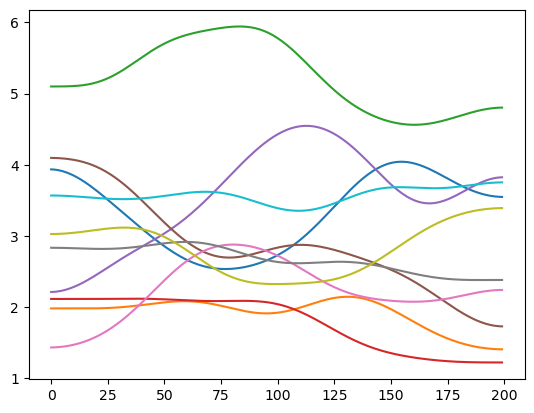

In [44]:
for i in range(10):
    plt.plot(sub_data[i])
plt.show()

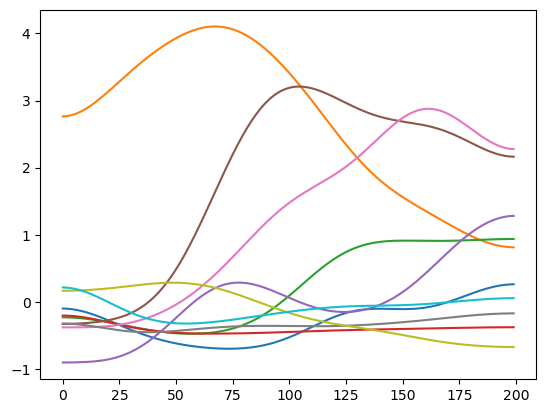

In [13]:
for i in range(10):
    plt.plot(ex[i])
plt.show()

In [15]:
ex, ex.shape

(array([[-0.09941599, -0.10041544, -0.10240879, ...,  0.25922911,
          0.2609978 ,  0.26188377],
        [ 2.76295081,  2.76507277,  2.76930082, ...,  0.81573264,
          0.81374065,  0.81274206],
        [-0.23040735, -0.23079819, -0.23157929, ...,  0.93716011,
          0.93741567,  0.93754294],
        ...,
        [-0.9014612 , -0.90152734, -0.90165909, ..., -0.83852669,
         -0.83821604, -0.83806022],
        [-0.20971398, -0.21008415, -0.21082154, ..., -0.24224178,
         -0.2424192 , -0.24250877],
        [-0.1611538 , -0.16152358, -0.16226429, ..., -0.77193586,
         -0.77236708, -0.77258273]]),
 (365, 200))

In [19]:
sub_data

array([[3.93430084, 3.93263003, 3.92930145, ..., 3.55021137, 3.54823563,
        3.54724835],
       [1.9800354 , 1.98003282, 1.97999573, ..., 1.40611371, 1.40512254,
        1.4046263 ],
       [5.0996665 , 5.09969499, 5.09978209, ..., 4.80070475, 4.8022604 ,
        4.80303798],
       ...,
       [3.85784942, 3.85734255, 3.85631012, ..., 3.71337269, 3.71197429,
        3.71125556],
       [0.49651319, 0.49653484, 0.49658918, ..., 0.47329074, 0.47336174,
        0.47339888],
       [2.55619807, 2.55663436, 2.55752322, ..., 2.54705413, 2.54589921,
        2.54532211]])

In [45]:
target = sub_data

In [46]:
target_transposed = np.transpose(target).astype(np.float32) # convert to shape (timestep, number of neurons)
u = 1 # number of inputs, by default the forward pass does not use inputs so this is a stand-in
n = target_transposed.shape[1] # number of neurons
tau = 1.5 # neuron time constant
dt = 0.25 # time step
alpha = 1 # gain on P matrix at initialization
m = n # output dim equals the number of recurrent neurons
g = 1.25 # gain parameter controlling network chaos
p_recurr = 0.2 # (1 - p_recurr) of recurrent weights are randomly set to 0 and not trained
max_epoch = 50

structural_connectivity = np.ones((n, n)) # region connectivity matrix; set to all 1's since only looking at one subsection of the brain
noise_param = (0, 0.001) # mean and std of white noise injected to the forward pass

x_t = np.zeros((target_transposed.shape[0], u)).astype(np.float32) # stand-in input

In [25]:
target.shape, target_transposed, target_transposed.shape, structural_connectivity, structural_connectivity.shape, x_t, x_t.shape

((365, 200),
 array([[-0.09941599,  2.762951  , -0.23040734, ..., -0.9014612 ,
         -0.20971398, -0.1611538 ],
        [-0.10041544,  2.7650728 , -0.2307982 , ..., -0.90152735,
         -0.21008416, -0.16152358],
        [-0.10240879,  2.769301  , -0.23157929, ..., -0.9016591 ,
         -0.21082154, -0.16226429],
        ...,
        [ 0.25922912,  0.81573266,  0.93716013, ..., -0.83852667,
         -0.24224178, -0.7719359 ],
        [ 0.2609978 ,  0.8137407 ,  0.93741566, ..., -0.83821607,
         -0.2424192 , -0.77236706],
        [ 0.26188377,  0.81274205,  0.9375429 , ..., -0.8380602 ,
         -0.24250877, -0.7725827 ]], dtype=float32),
 (200, 365),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 (365, 365),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],


In [28]:
target.shape, target_transposed, target_transposed.shape, structural_connectivity, structural_connectivity.shape, x_t, x_t.shape

((335, 200),
 array([[3.934301  , 1.9800354 , 5.0996666 , ..., 3.8578494 , 0.4965132 ,
         2.5561981 ],
        [3.93263   , 1.9800328 , 5.099695  , ..., 3.8573425 , 0.49653485,
         2.5566344 ],
        [3.9293015 , 1.9799957 , 5.099782  , ..., 3.8563101 , 0.49658918,
         2.5575233 ],
        ...,
        [3.5502114 , 1.4061137 , 4.800705  , ..., 3.7133727 , 0.47329074,
         2.547054  ],
        [3.5482357 , 1.4051225 , 4.8022604 , ..., 3.7119744 , 0.47336173,
         2.5458992 ],
        [3.5472484 , 1.4046263 , 4.803038  , ..., 3.7112556 , 0.47339886,
         2.5453222 ]], dtype=float32),
 (200, 335),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 (335, 335),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        

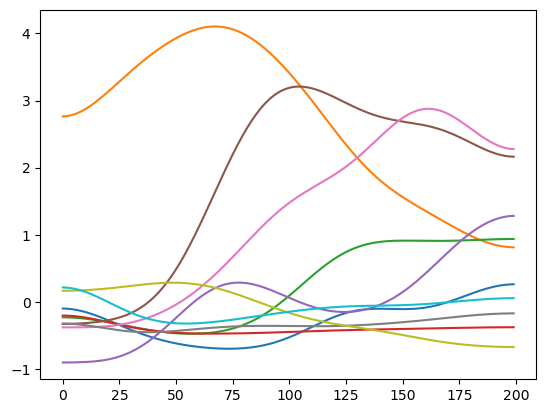

In [27]:
for i in range(10):
    plt.plot(ex[i])
plt.show()

Text(0, 0.5, 'PC2')

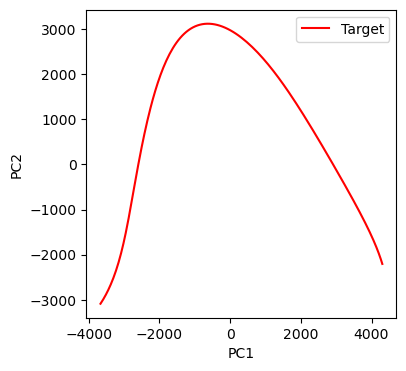

In [33]:
pca = PCA(n_components=2)
target_pca = pca.fit_transform(sub_data.T)
pred_pca = pca.transform(sub_data.T)

plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [38]:
ex.shape, sub_data.shape

((365, 200), (335, 200))

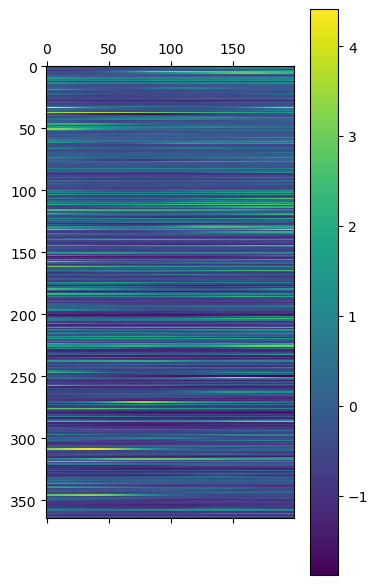

In [20]:
plt.matshow(ex)
plt.colorbar()

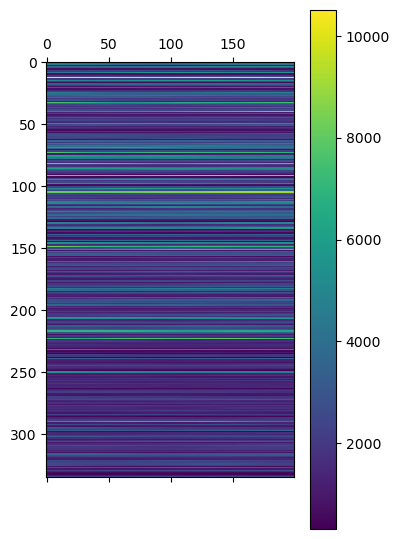

In [34]:
plt.matshow(sub_data)
plt.colorbar()

In [35]:
target = sub_data
target_transposed = np.transpose(target).astype(np.float32) # convert to shape (timestep, number of neurons)
u = 1 # number of inputs, by default the forward pass does not use inputs so this is a stand-in
n = target_transposed.shape[1] # number of neurons
tau = 1.5 # neuron time constant
dt = 0.25 # time step
alpha = 1 # gain on P matrix at initialization
m = n # output dim equals the number of recurrent neurons
g = 1.25 # gain parameter controlling network chaos
p_recurr = 0.5 # (1 - p_recurr) of recurrent weights are randomly set to 0 and not trained
max_epoch = 40

structural_connectivity = np.ones((n, n)) # region connectivity matrix; set to all 1's since only looking at one subsection of the brain
noise_param = (0, 0.001) # mean and std of white noise injected to the forward pass

x_t = np.zeros((target_transposed.shape[0], u)).astype(np.float32) # stand-in input

In [47]:
%%time
tf.random.set_seed(123)

earlystopping = EarlyStoppingByLossVal(monitor="val_mae", value=0.25)
esn_layer = ConstrainedNoFeedbackESN(units=n,
                                     activation='tanh',
                                     dtdivtau=dt/tau,
                                     p_recurr=p_recurr,
                                     structural_connectivity=structural_connectivity,
                                     noise_param=noise_param,
                                     seed=123)

model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
model.compile(metrics=["mae"])

# pass the input as validation data for early stopping
history = model.fit(x=x_t, 
                    y=target_transposed, 
                    epochs=max_epoch,
                    callbacks=[earlystopping],
                    validation_data=(x_t, target_transposed))

Epoch 1/50
200/200 [==============================] - 31s 155ms/step - mae: 0.9931 - val_loss: 0.3474 - val_mae: 0.3474
Epoch 2/50
200/200 [==============================] - 20s 98ms/step - mae: 0.3320 - val_loss: 0.3218 - val_mae: 0.3218
Epoch 3/50
200/200 [==============================] - 23s 116ms/step - mae: 0.3200 - val_loss: 0.3184 - val_mae: 0.3184
Epoch 4/50
200/200 [==============================] - 18s 90ms/step - mae: 0.3174 - val_loss: 0.3174 - val_mae: 0.3174
Epoch 5/50
200/200 [==============================] - 22s 112ms/step - mae: 0.3165 - val_loss: 0.3169 - val_mae: 0.3169
Epoch 6/50
200/200 [==============================] - 22s 111ms/step - mae: 0.3161 - val_loss: 0.3167 - val_mae: 0.3167
Epoch 7/50
200/200 [==============================] - 23s 113ms/step - mae: 0.3159 - val_loss: 0.3166 - val_mae: 0.3166
Epoch 8/50
200/200 [==============================] - 16s 78ms/step - mae: 0.3158 - val_loss: 0.3165 - val_mae: 0.3165
Epoch 9/50
200/200 [=======================

In [53]:
%%time
tf.random.set_seed(123)

earlystopping = EarlyStoppingByLossVal(monitor="val_mae", value=0.25)
esn_layer = ConstrainedNoFeedbackESN(units=n,
                                     activation='tanh',
                                     dtdivtau=dt/tau,
                                     p_recurr=0.1,
                                     structural_connectivity=structural_connectivity,
                                     noise_param=noise_param,
                                     seed=123)

model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
model.compile(metrics=["mae"])

# pass the input as validation data for early stopping
history = model.fit(x=x_t, 
                    y=target_transposed, 
                    epochs=max_epoch,
                    callbacks=[earlystopping],
                    validation_data=(x_t, target_transposed))

Epoch 1/40
200/200 [==============================] - 22s 107ms/step - mae: 0.9180 - val_loss: 0.3342 - val_mae: 0.3342
Epoch 2/40
200/200 [==============================] - 21s 103ms/step - mae: 0.3245 - val_loss: 0.3185 - val_mae: 0.3185
Epoch 3/40
200/200 [==============================] - 19s 94ms/step - mae: 0.3177 - val_loss: 0.3167 - val_mae: 0.3167
Epoch 4/40
200/200 [==============================] - 18s 92ms/step - mae: 0.3164 - val_loss: 0.3163 - val_mae: 0.3163
Epoch 5/40
200/200 [==============================] - 16s 81ms/step - mae: 0.3160 - val_loss: 0.3161 - val_mae: 0.3161
Epoch 6/40
200/200 [==============================] - 16s 78ms/step - mae: 0.3159 - val_loss: 0.3161 - val_mae: 0.3161
Epoch 7/40
200/200 [==============================] - 16s 82ms/step - mae: 0.3159 - val_loss: 0.3161 - val_mae: 0.3161
Epoch 8/40
200/200 [==============================] - 16s 81ms/step - mae: 0.3158 - val_loss: 0.3161 - val_mae: 0.3161
Epoch 9/40
200/200 [==========================

KeyboardInterrupt: 

In [11]:
x_t.shape

(200, 1)

In [40]:
%%time
prediction = model.predict(x_t)
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed)))

200/200 [==============================] - 0s 579us/step
tf.Tensor(133.82347, shape=(), dtype=float32)
CPU times: user 395 ms, sys: 45.9 ms, total: 441 ms
Wall time: 346 ms


Text(0.5, 0, 'Time (s)')

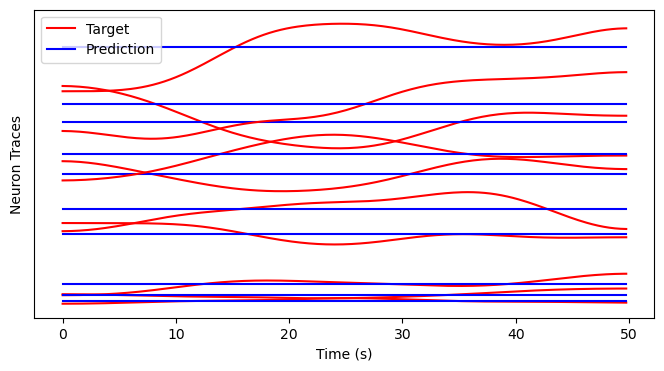

In [41]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
num_plot = np.arange(10)

for idx, i in enumerate(num_plot):
  ax.plot(np.arange(0, x_t.shape[0]) * dt, target_transposed[:,i] + 10 * idx, color='r')
  ax.plot(np.arange(0, x_t.shape[0]) * dt, prediction[:,i] + 10 * idx, color='b')
  if i == num_plot[-1]:
    ax.legend(['Target', 'Prediction'])
ax.set_yticks([])
ax.set_ylabel('Neuron Traces')
ax.set_xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

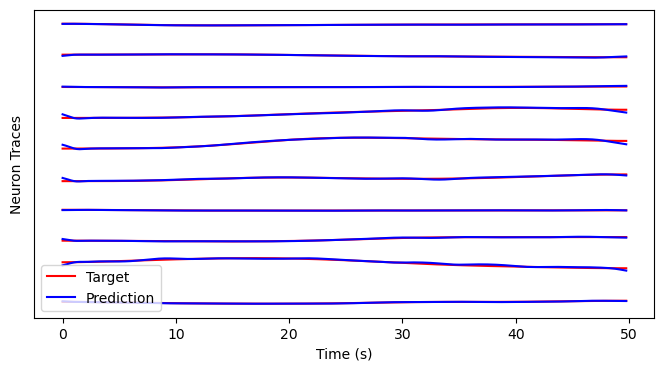

In [31]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
num_plot = np.arange(10)

for idx, i in enumerate(num_plot):
  ax.plot(np.arange(0, x_t.shape[0]) * dt, target_transposed[:,i] + 10 * idx, color='r')
  ax.plot(np.arange(0, x_t.shape[0]) * dt, prediction[:,i] + 10 * idx, color='b')
  if i == num_plot[-1]:
    ax.legend(['Target', 'Prediction'])
ax.set_yticks([])
ax.set_ylabel('Neuron Traces')
ax.set_xlabel('Time (s)')

In [16]:
ex.shape, prediction.T.shape

((365, 200), (365, 200))

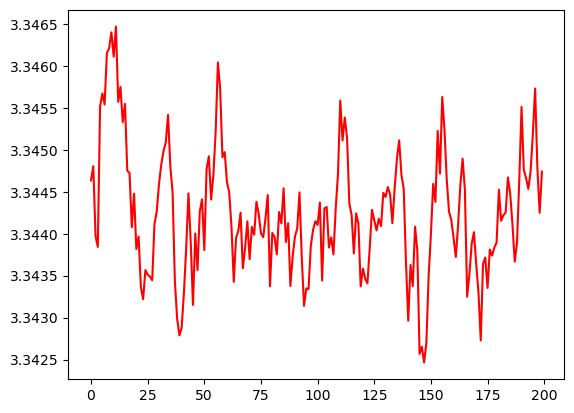

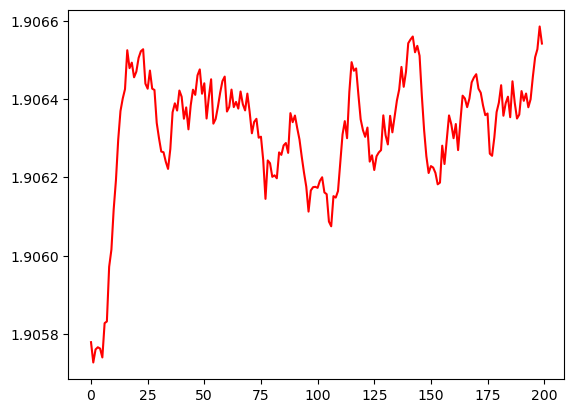

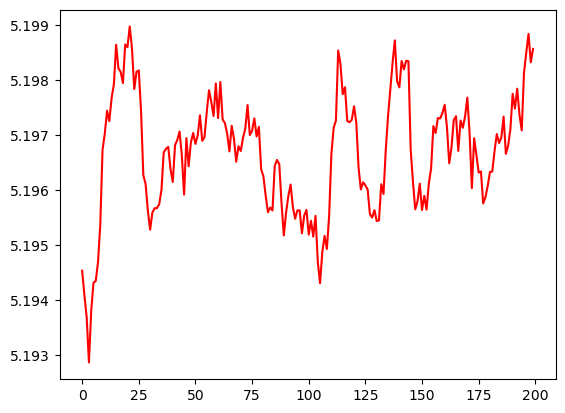

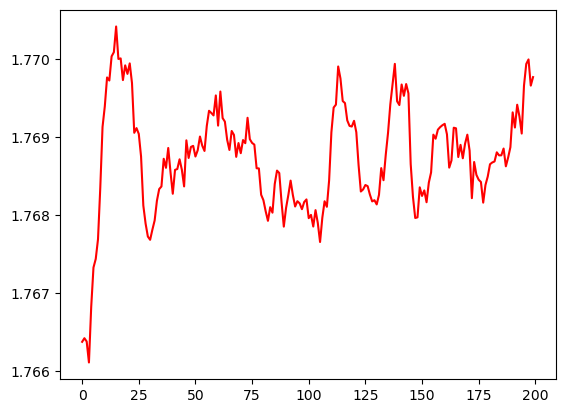

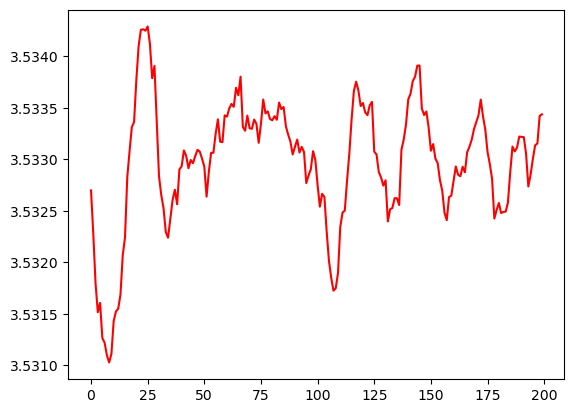

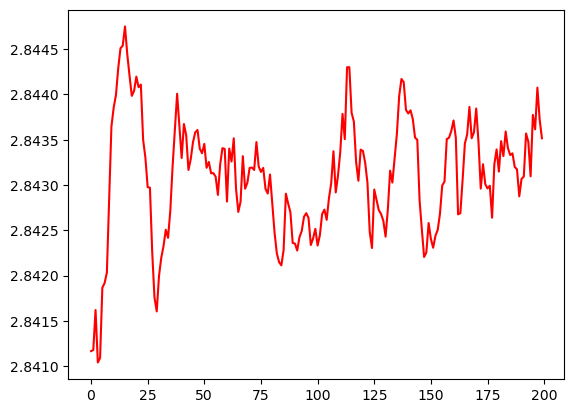

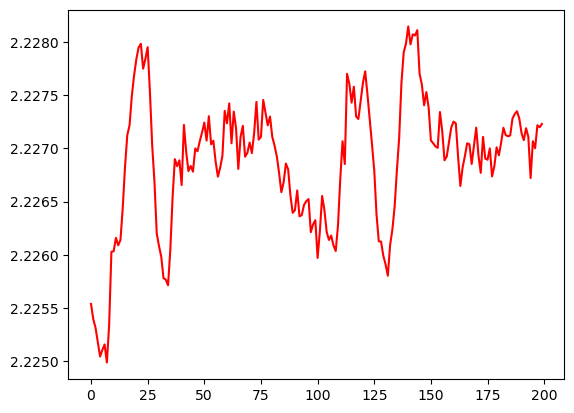

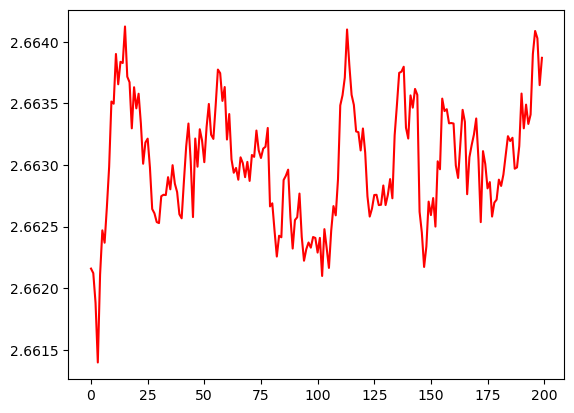

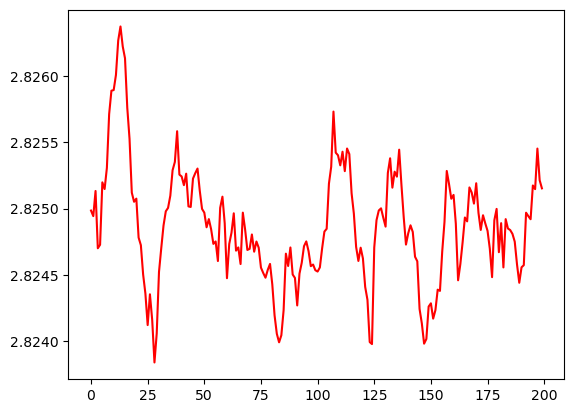

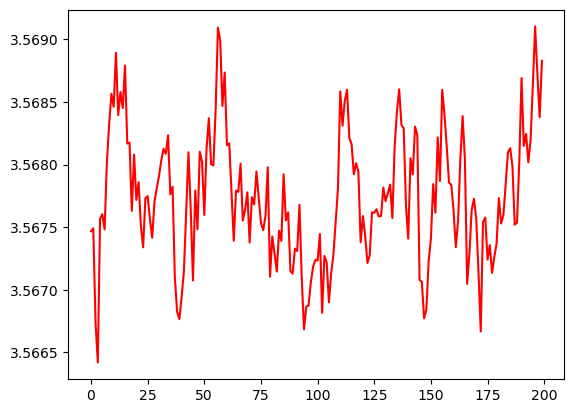

In [52]:
for i in range(10):
    #plt.plot(sub_data[i])
    plt.plot(prediction.T[i], c='red')
    plt.show()

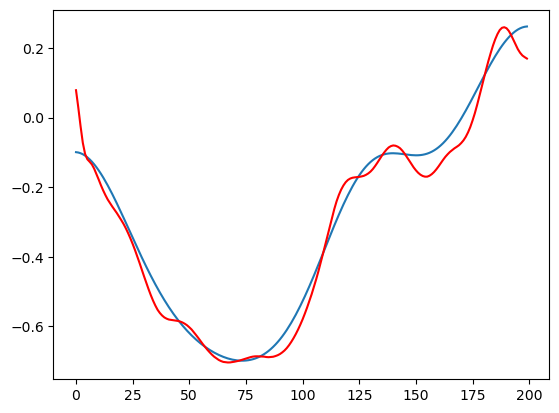

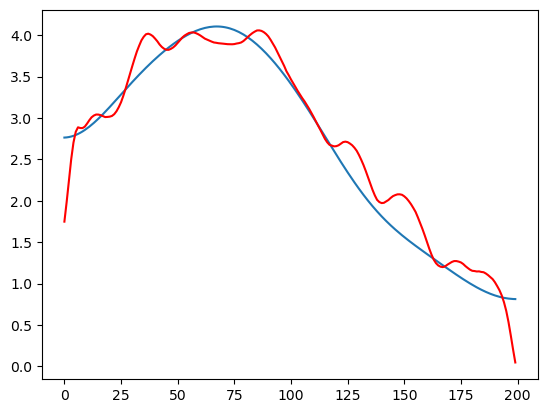

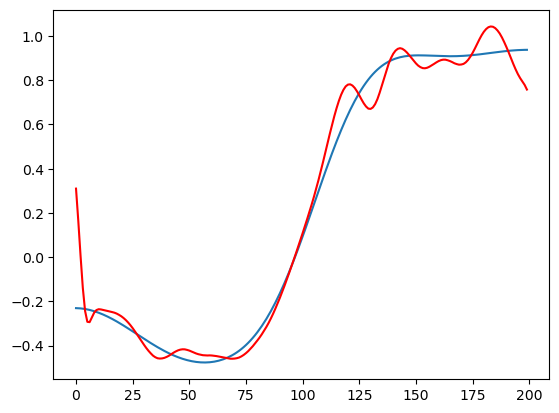

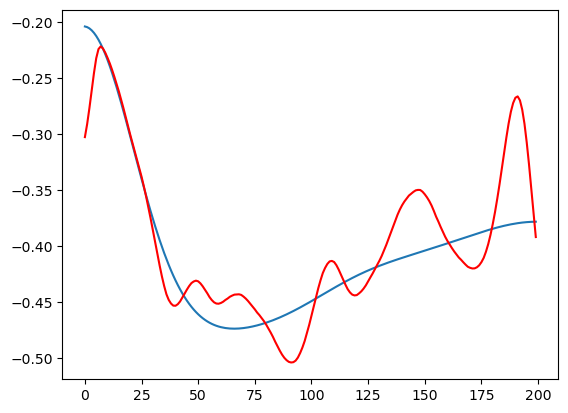

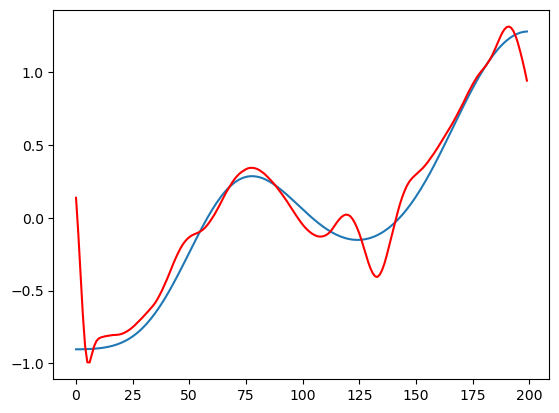

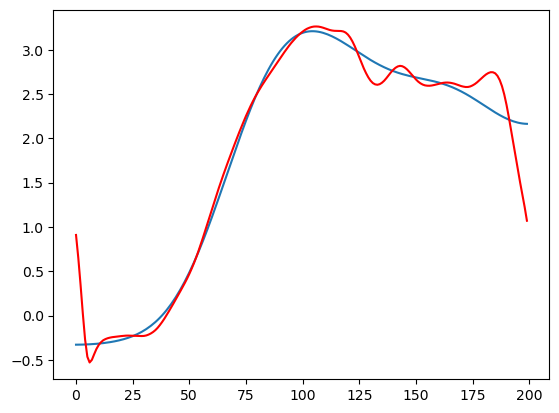

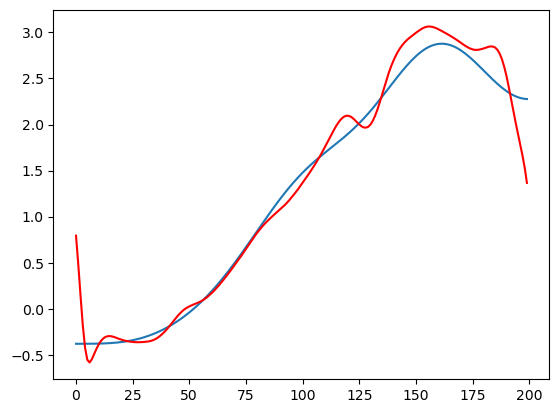

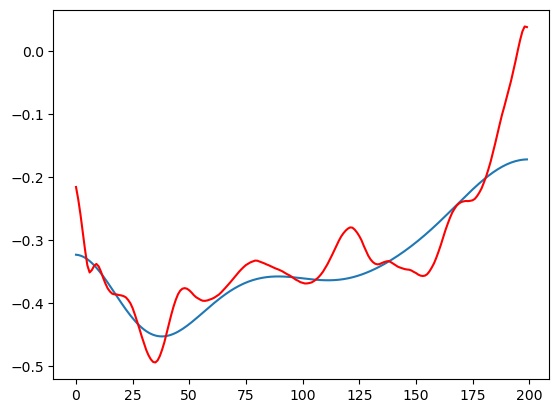

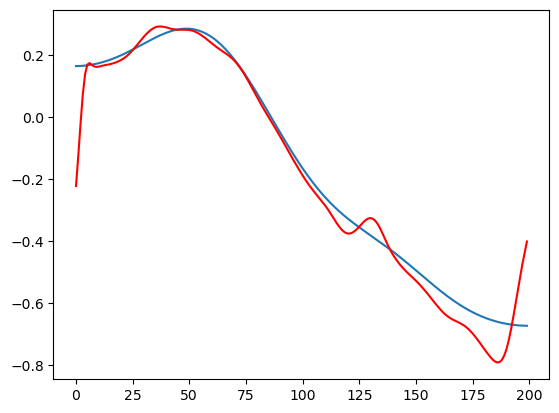

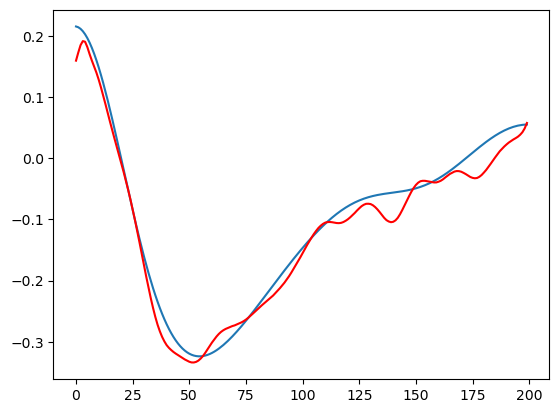

In [32]:
for i in range(10):
    plt.plot(ex[i])
    plt.plot(prediction.T[i], c='red')
    plt.show()

Text(0, 0.5, 'PC2')

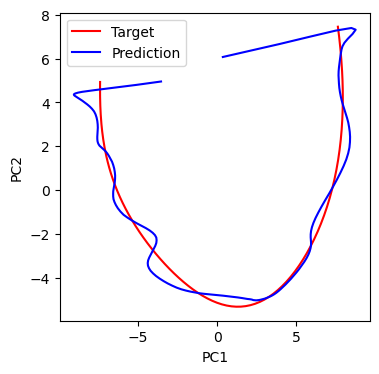

In [33]:
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed)
pred_pca = pca.transform(prediction)

plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 'PC2')

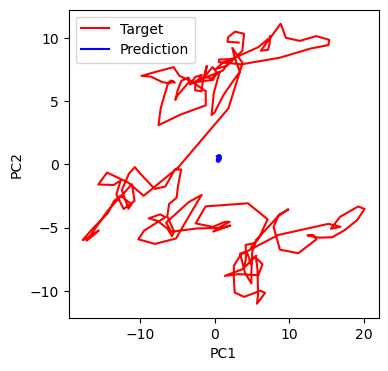

In [14]:
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed)
pred_pca = pca.transform(prediction)

plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0.5, 0, 'Time (s)')

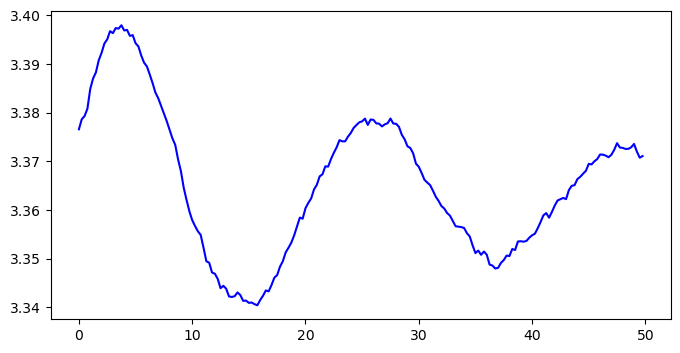

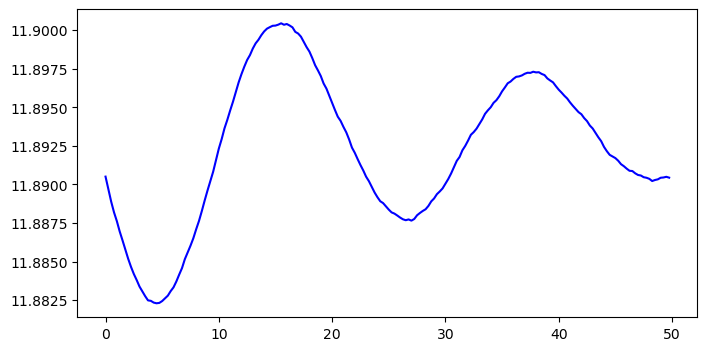

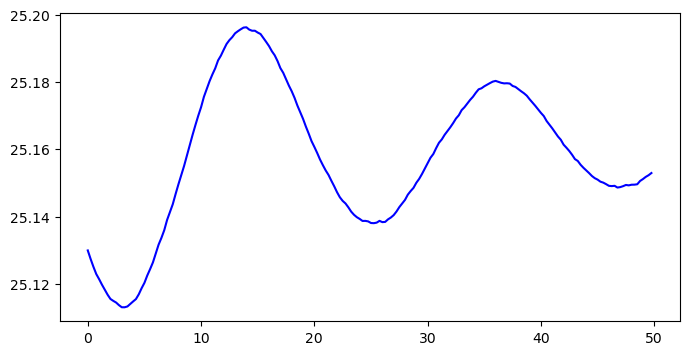

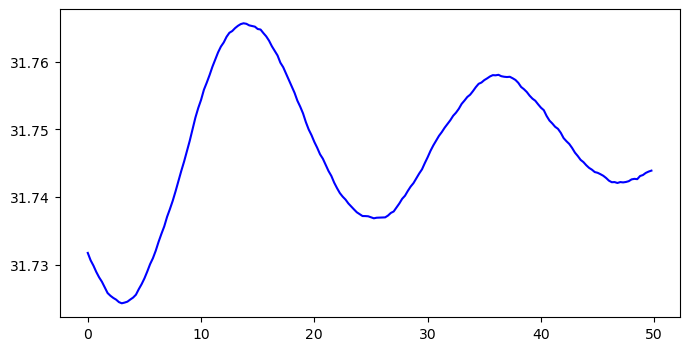

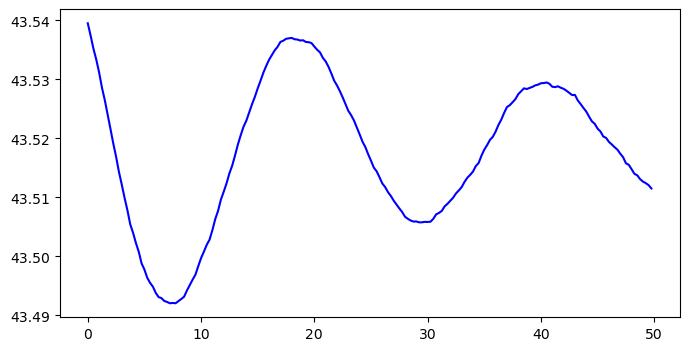

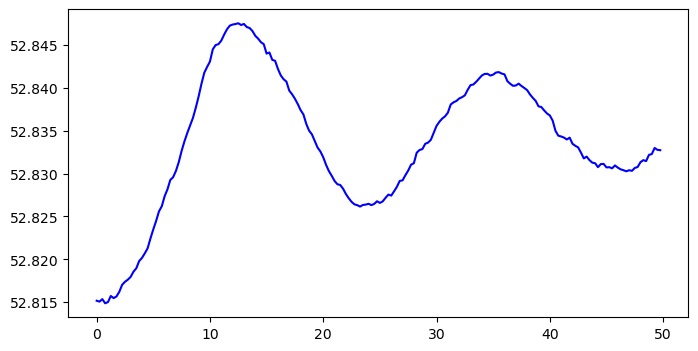

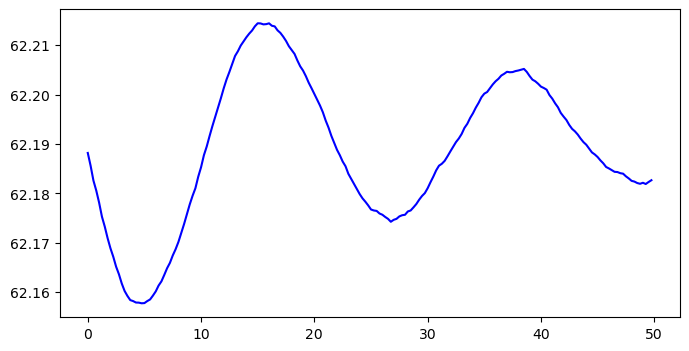

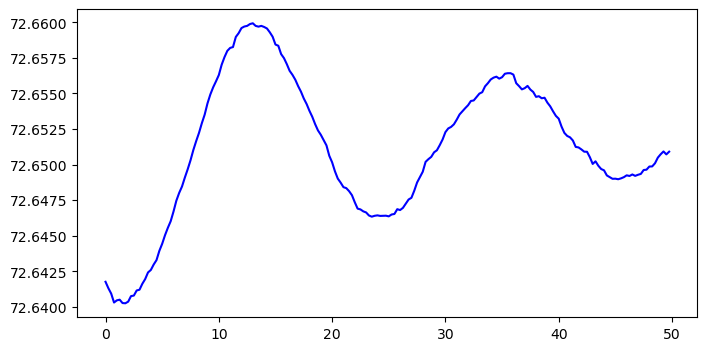

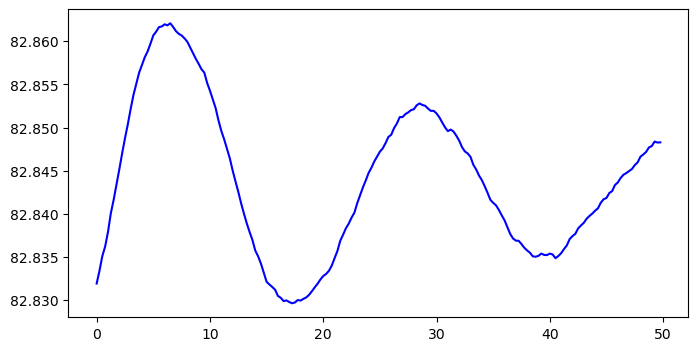

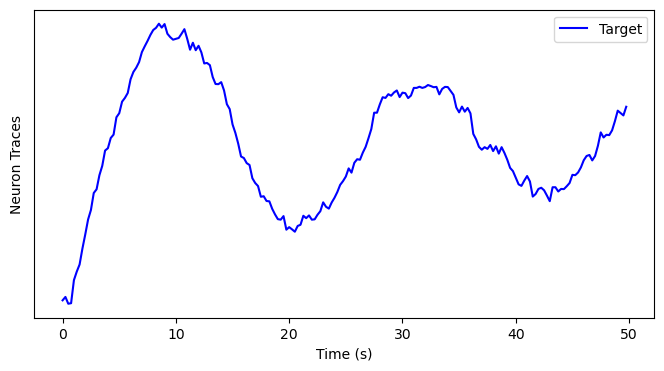

In [17]:
num_plot = np.arange(10)

for idx, i in enumerate(num_plot):
  fig, ax = plt.subplots(1,1, figsize = (8,4))

  ax.plot(np.arange(0, x_t.shape[0]) * dt, prediction[:,i] + 10 * idx, color='b')
  if i == num_plot[-1]:
    ax.legend(['Target', 'Prediction'])
ax.set_yticks([])
ax.set_ylabel('Neuron Traces')
ax.set_xlabel('Time (s)')